In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Flatten

Попробуем предсказать цены на квартиры при помощи нейросети, пользуясь параметрами наших данных. Загрузим наши данные, а далее создадим модель для предсказания цены.


---
Посмотрим на данные


In [127]:
df_0 = pd.read_csv('flats_moscow.csv')


In [115]:
df_0

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...
2035,2036,110,77,45,10.0,12.0,5,0,0,1,5
2036,2037,95,60,43,6.0,9.0,5,0,0,1,4
2037,2038,95,60,46,5.0,10.5,5,1,0,1,7
2038,2039,129,76,48,10.0,12.5,5,0,0,1,3


**price** – цена квартиры в $1000

**totsp** – общая площадь квартиры, кв.м.

**livesp** –
жилая площадь квартиры, кв.м.

**kitsp** –
площадь кухни, кв.м.

**dist** –
расстояние от центра в км.

**metrdist** –
расстояние до метро в минутах

**walk** –
1 – пешком от метро, 0 – на транспорте

**brick** –
1 – кирпичный, монолит ж/б, 0 – другой

**floor** –
1 – этаж кроме первого и последнего, 0 – иначе.

**code** –
число от 1 до 8, при помощи которого мы группируем наблюдения по подвыборкам:
 1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии метрополитена
 2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена
 3. Северо-запад, вокруг Замоскворецкой линии метрополитена
 4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена
 5. Юго-восток, вокруг Люблинской линии метрополитена
 6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена
 7. Восток, вокруг Калиниской линии метрополитена
 8. Восток, вокруг Арбатско-Покровской линии метрополитена

In [128]:
names = df_0.columns[1:]

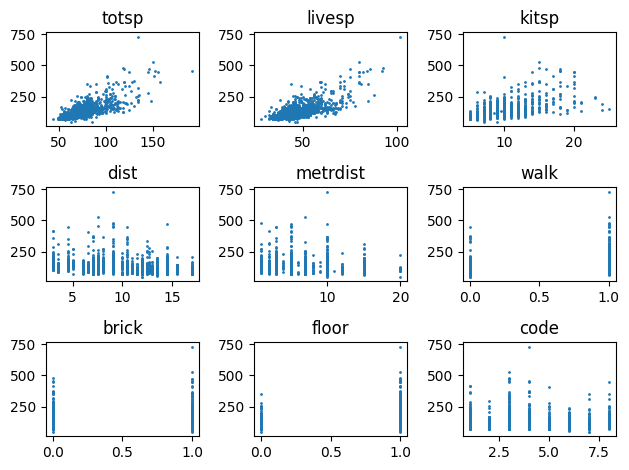

In [129]:
for i in range(1, len(names)):
  plt.subplot(3, 3, i)
  plt.scatter(df_0[names[i]], df_0[names[0]], s=1)
  plt.title(names[i])

plt.tight_layout()

На многих графиках можно заметить выбросы, которые будут плохо влиять на обучение модели. Она будет построена на среднем квадрате ошибки, из-за чего будет подстраиваться под выбросы больше, чем под основные данные. Удалим эти выбросы, взяв порог в price = 400

In [130]:
df_0 = df_0.drop(df_0[df_0['price'] > 400].index)
df_0 = df_0.reset_index(drop=True)

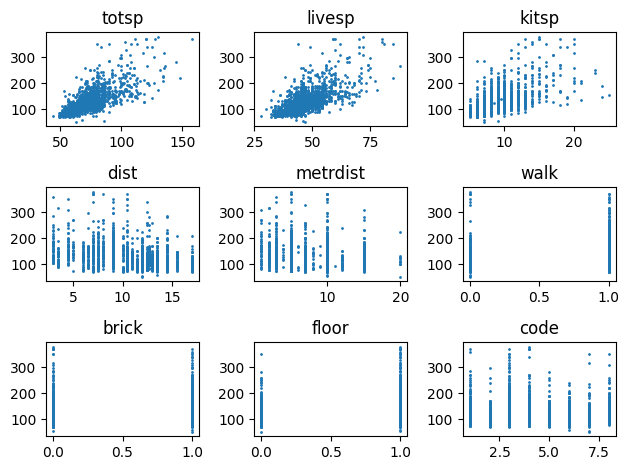

In [131]:
for i in range(1, len(names)):
  plt.subplot(3, 3, i)
  plt.scatter(df_0[names[i]], df_0[names[0]], s=1)
  plt.title(names[i])

plt.tight_layout()

Так намного лучше

Можем заметить, что параметры *walk*, *brick*, *floor* не сильно помогут нам в предсказании цены, поэтому их лучше отбросить

In [132]:
df = df_0.loc[:, ['price', 'totsp', 'livesp', 'kitsp', 'dist', 'metrdist', 'code']]

Теперь нормализуем данные, но заметим, что колонка code - это категориальный признак. Не будем трогать его при нормализации, но далее воспользуемся методом one-hot encoding для представления этой колонкки

In [133]:
mx_price = df['price'].max()

for name in df.columns[:-1]:
  df[name] = df[name] / df[name].max()

Также, запомним значение *max_price* для того, чтобы после обработки данных нейросетью перевести их обратно в привычный вид

In [134]:
mx_price

380

In [135]:
df

,price,totsp,livesp,kitsp,dist,metrdist,code
0,0.213158,0.367089,0.454545,0.24,0.735294,0.35,3
1,0.197368,0.278481,0.318182,0.24,0.794118,0.35,6
2,0.336842,0.443038,0.477273,0.24,0.852941,0.15,3
3,0.250000,0.386076,0.420455,0.24,0.794118,0.35,1
4,0.868421,0.658228,0.681818,0.44,0.617647,0.35,3
...,...,...,...,...,...,...,...
2022,0.289474,0.487342,0.511364,0.40,0.705882,0.25,5
2023,0.250000,0.379747,0.488636,0.24,0.529412,0.25,4
2024,0.250000,0.379747,0.522727,0.20,0.617647,0.25,7
2025,0.339474,0.481013,0.545455,0.40,0.735294,0.25,3


Закодируем дискретные значения колонки *code*


In [136]:
df = pd.get_dummies(df, columns=['code'], prefix=['code'])

In [137]:
df

,price,totsp,livesp,kitsp,dist,metrdist,code_1,code_2,code_3,code_4,code_5,code_6,code_7,code_8
0,0.213158,0.367089,0.454545,0.24,0.735294,0.35,0,0,1,0,0,0,0,0
1,0.197368,0.278481,0.318182,0.24,0.794118,0.35,0,0,0,0,0,1,0,0
2,0.336842,0.443038,0.477273,0.24,0.852941,0.15,0,0,1,0,0,0,0,0
3,0.250000,0.386076,0.420455,0.24,0.794118,0.35,1,0,0,0,0,0,0,0
4,0.868421,0.658228,0.681818,0.44,0.617647,0.35,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,0.289474,0.487342,0.511364,0.40,0.705882,0.25,0,0,0,0,1,0,0,0
2023,0.250000,0.379747,0.488636,0.24,0.529412,0.25,0,0,0,1,0,0,0,0
2024,0.250000,0.379747,0.522727,0.20,0.617647,0.25,0,0,0,0,0,0,1,0
2025,0.339474,0.481013,0.545455,0.40,0.735294,0.25,0,0,1,0,0,0,0,0


Теперь преобразуем наш ДатаФрейм в массивы *numpy* и разделим данные на обучающую
и тестовую выборки

In [138]:
prices = np.array(df['price'])
parameters = np.array(df.loc[:, 'livesp':'code_8'])

n = int(len(parameters) * 0.8)

prices_train = prices[:n]
prices_test = prices[n:]

parameters_train = parameters[:n]
parameters_test = parameters[n:]

In [139]:
print(prices_train)
print(parameters_train)

[0.21315789 0.19736842 0.33684211 ... 0.27105263 0.24473684 0.65789474]
[[0.45454545 0.24       0.73529412 ... 0.         0.         0.        ]
 [0.31818182 0.24       0.79411765 ... 1.         0.         0.        ]
 [0.47727273 0.24       0.85294118 ... 0.         0.         0.        ]
 ...
 [0.51136364 0.4        0.70588235 ... 0.         0.         0.        ]
 [0.5        0.24       1.         ... 0.         0.         0.        ]
 [0.53409091 0.4        0.61764706 ... 0.         0.         0.        ]]


**Создаем нейросеть**

---

Для обучения будем использовать функцию активации *relu*, а функцию потерь возьмем как средний квадрат ошибки

In [140]:
model = keras.Sequential()
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse',  metrics=['mae'])

In [141]:
fit_results = model.fit(parameters_train, prices_train, batch_size=50, epochs=15, validation_split=0.2, validation_data=(parameters_test, prices_test))

Epoch 1/15
33/33 [==============================] - 1s 9ms/step - loss: 0.0427 - mae: 0.1571 - val_loss: 0.0145 - val_mae: 0.0930
Epoch 2/15
33/33 [==============================] - 0s 4ms/step - loss: 0.0107 - mae: 0.0726 - val_loss: 0.0093 - val_mae: 0.0626
Epoch 3/15
33/33 [==============================] - 0s 3ms/step - loss: 0.0084 - mae: 0.0624 - val_loss: 0.0080 - val_mae: 0.0579
Epoch 4/15
33/33 [==============================] - 0s 4ms/step - loss: 0.0075 - mae: 0.0582 - val_loss: 0.0072 - val_mae: 0.0546
Epoch 5/15
33/33 [==============================] - 0s 5ms/step - loss: 0.0069 - mae: 0.0554 - val_loss: 0.0068 - val_mae: 0.0526
Epoch 6/15
33/33 [==============================] - 0s 5ms/step - loss: 0.0065 - mae: 0.0541 - val_loss: 0.0064 - val_mae: 0.0511
Epoch 7/15
33/33 [==============================] - 0s 5ms/step - loss: 0.0062 - mae: 0.0520 - val_loss: 0.0060 - val_mae: 0.0498
Epoch 8/15
33/33 [==============================] - 0s 6ms/step - loss: 0.0058 - mae: 0.05

In [142]:
model.evaluate(parameters_test, prices_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.0047 - mae: 0.0441


[0.00466946791857481, 0.04407237842679024]

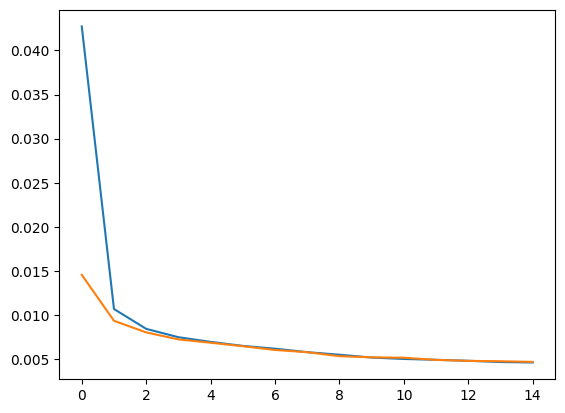

In [143]:
plt.plot(fit_results.history['loss'], label='train')
plt.plot(fit_results.history['val_loss'], label='value')

График потерь не содержит аномалий, он равномерно убывает. Модель не слишком переобучается

---
Теперь проверим нашу модель на тестовых данных


In [144]:
res = model.predict(parameters_test)
res *= mx_price

13/13 [==============================] - 0s 3ms/step


In [145]:
df_0 = df_0.drop(df_0[df_0['price'] > 400].index)
df_0 = df_0.reset_index(drop=True)
data = df_0.iloc[n:][:]
data['price_pred'] = res.round()


In [146]:
data[['price', 'price_pred']]


,price,price_pred
1621,117,114.0
1622,145,114.0
1623,164,128.0
1624,130,122.0
1625,78,79.0
...,...,...
2022,110,116.0
2023,95,114.0
2024,95,92.0
2025,129,144.0


Построим график отклонений предсказанных занчений

Text(0, 0.5, 'predicted prices')

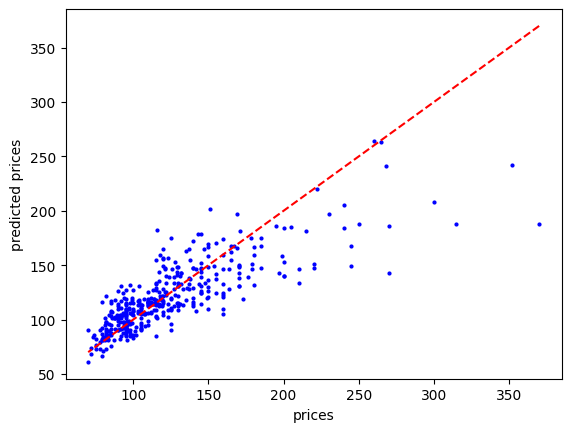

In [147]:
plt.scatter(data['price'], data['price_pred'], c='b', s=4)
plt.plot([max(data['price']), min(data['price'])],
         [max(data['price']), min(data['price'])],
         color='r', linestyle='--'
         )
plt.xlabel('prices')
plt.ylabel('predicted prices')

Нейросеть достаточно хорошо определила большую часть цен. Также присутствуют и аномальные значения, но их количество крайне мало. Появление аномалий может быть обусловлено недостатком некоторых данных, например, этаж, на котором расположена квартира, или .  